In [1]:
import pandas as pd
data_df = pd.read_csv('train.csv')
data_df.head()

,filename,label
0,train/0.jpg,(0+0)+9=9
1,train/1.jpg,9*8+6=78
2,train/2.jpg,1+7+0=8
3,train/3.jpg,5+4+9=18
4,train/4.jpg,7-(1*7)=0


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np 
random_state=1
train_df, test_df = train_test_split(data_df, test_size=2000, random_state=random_state)
train_df, valid_df = train_test_split(train_df, test_size=2000, random_state=random_state)
print('train data size: ', len(train_df))
print('valid data size: ', len(valid_df))
print('test  data size: ', len(test_df))

X_train, Y_train = (np.array(train_df['filename']), np.array(train_df['label']))
X_valid, Y_valid = (np.array(valid_df['filename']), np.array(valid_df['label']))
X_test, Y_test = (np.array(test_df['filename']), np.array(test_df['label']))

print(X_train[0:4])
print(Y_train[0:4])

train data size:  96000
valid data size:  2000
test  data size:  2000
['train/1636.jpg' 'train/60389.jpg' 'train/10990.jpg' 'train/8179.jpg']
['6+(5-7)=4' '7-5-4=-2' '6*(6-7)=-6' '(1+0)+8=9']


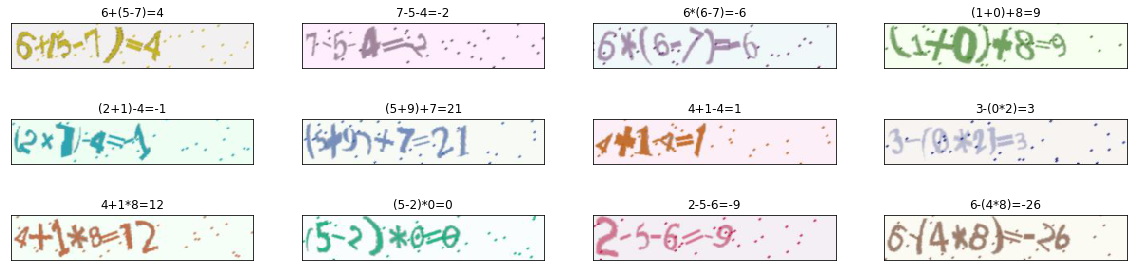

In [10]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 48))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(20,5))
for i in range(12):
    label = Y_train[i]
    ax = fig.add_subplot(3,4, i+1,xticks=[],yticks=[], title=label)
    visualize_img(X_train[i], ax)

In [ ]:
# img = cv2.imread(X_train[0])
# print(img.shape)
# print(img)

In [ ]:
# test = map(lambda x: x **2, range(9))
# print(test)
# for i in test:
#     print(i) 
# help(list)

In [4]:
from collections import defaultdict

char_counter= defaultdict(lambda: 0)

def count(x):
    for i in x:
        char_counter[i] += 1

labels = np.array(data_df['label'])

list(map(count, labels))
print(char_counter)
print('max lenght: ', np.max(list(map(lambda x: len(x), labels))))

defaultdict(<function <lambda> at 0x7f256ba05f28>, {'(': 66487, '0': 46522, '+': 66517, ')': 66487, '9': 37251, '=': 100000, '*': 66668, '8': 40008, '6': 42535, '7': 38880, '1': 64228, '5': 42278, '4': 45867, '-': 89396, '3': 44442, '2': 51072})
max lenght:  11


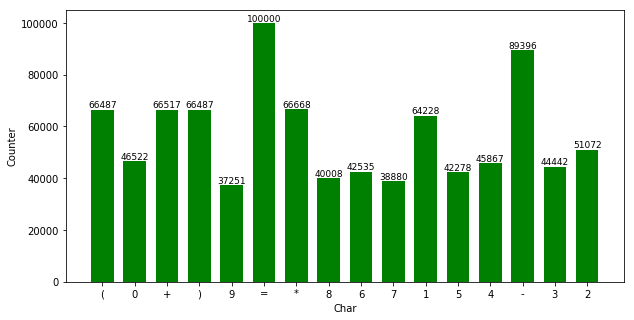

In [5]:
fig = plt.figure(figsize=(10, 5))
plt.bar(char_counter.keys(), char_counter.values(), width=0.7, color='g')
plt.ylabel('Counter')
plt.xlabel('Char')
for key, value in char_counter.items():
    plt.text(key,value,'%d' % value, ha='center', va='bottom', fontsize=9)
    

In [6]:
char_vector = np.array(['0','1','2','3','4','5','6','7','8','9','(',')','+',"-",'*','='])
# print(len(char_counter.keys()))
# print(len(char_vector))
print(char_vector.shape)


def label_to_char(label):
    return char_vector[label]

def char_to_label(char):
    return np.argwhere(char_vector == char)[0][0]

def labels_to_expression(labels):
    return ''.join(list(map(lambda x: label_to_char(x),labels)))

def expression_to_labels(expression):
    return list(map(lambda x: char_to_label(x),list(expression)))


l1 = char_to_label('=')
c1 = label_to_char(l1)
print(l1)
print(c1)

ls1 = [1,12, 7, 14, 9, 15, 1, 2]
ex1 = labels_to_expression(ls1)
ls2 = expression_to_labels(ex1)
print(ex1)
print(ls2)


(16,)
15
=
1+7*9=12
[1, 12, 7, 14, 9, 15, 1, 2]


In [26]:
img_w = 256
img_h = 48
n_classes = len(char_vector) + 1
max_exp_len = 11

In [13]:
import cv2
import random

class TensorGenerator:
    
    def __init__(self, img_paths, expressions, img_w, img_h, batch_size, max_exp_len):
        self.img_paths = img_paths
        self.expressions = expressions
        self.img_w = img_w
        self.img_h = img_h
        self.batch_size = batch_size
        self.max_exp_len = max_exp_len
        self.n = len(img_paths)
        self.indexes = list(range(self.n))
        self.next_index = 0
    
    def next_sample(self):
        index = self.indexes[self.next_index]
        self.next_index += 1
        if self.next_index >= self.n:
            self.next_index = 0
            random.shuffle(self.indexes)
        path = self.img_paths[index]
        labels = expression_to_labels(self.expressions[index])
#         print(path)
#         print(labels)
        
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.img_w, self.img_h))
        img = img.T
        img = img.astype(np.float32)
        img = (img / 255.0) * 2 - 1.0
        img = np.expand_dims(img, axis=2)
#         print(img.shape)
        return img, labels
        
    def next_batch(self):
        while True:
            
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_exp_len])
            
            input_length = np.ones([self.batch_size, 1]) * 32 # equal to the model define before push to rnn
            label_length = np.zeros([self.batch_size, 1])
            
            for i in range(self.batch_size):
                img, labels = self.next_sample()
                X_data[i] = img
                Y_data[i][0: len(labels)] = labels
                label_length[i] = len(labels)
#                 print(labels_to_expression(labels))
                
            inputs = {
                'the_inputs': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length
            }
            
            outputs = {
                'ctc':np.zeros([self.batch_size])
            }
#             print(inputs)
            
            yield(inputs, outputs)

In [ ]:
# generator_test = TensorGenerator(X_train, Y_train, img_w, img_h, 20, 11)
# f = generator_test.next_batch()
# r = f.__next__()
# print(r)

In [30]:
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import BatchNormalization, Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
#     y_pred = y_pred[:,2:]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def get_Model(training):

    K.set_learning_phase(training)
    
    # help(Model.fit_generator)
    input_shape = (img_w, img_h, 1) # (256, 48, 1)

    inputs = Input(name='the_inputs', shape=input_shape, dtype='float32') # (None, 256, 48, 1)

    inner = Conv2D(64, (3,3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs) # (None, 256, 48, 64)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2,2), name='max1')(inner) # (None, 128, 24, 64)
    
    inner = Conv2D(128, (3,3), padding='same', name='conv2', kernel_initializer='he_normal')(inner) # (None, 128, 24, 128)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2,1), name='max2')(inner) # (None, 64, 24, 128)

    inner = Conv2D(256, (3,3), padding='same', name='conv3', kernel_initializer='he_normal')(inner) # (None, 64, 24, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(256, (3,3), padding='same', name='conv4', kernel_initializer='he_normal')(inner) # (None, 64, 24, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1,2), name='max3')(inner) # (None, 64, 6, 256)

    inner = Conv2D(512, (3,3), padding='same', name='conv5', kernel_initializer='he_normal')(inner) # (None, 64, 12, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(512, (2,2), padding='same', name='conv6', kernel_initializer='he_normal')(inner) # (None, 64, 12, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2,2), name='max4')(inner) # (None, 32, 6, 512)

    inner = Conv2D(1024, (1,1), padding='same', name='conv7', kernel_initializer='he_normal')(inner) # (None, 32, 6, 1024)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)

    inner = Reshape(target_shape=((32, 6 * 1024)), name='reshape')(inner)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

    lstm_1 = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm_1')(inner)
    lstm_1b = LSTM(256, return_sequences=True, go_backwards=True,kernel_initializer='he_normal', name='lstm_1b')(inner)
    lstm1_merged = add([lstm_1, lstm_1b])
    lstm1_merged = BatchNormalization()(lstm1_merged)

    lstm_2 = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm_2')(lstm1_merged)
    lstm_2b = LSTM(256, return_sequences=True, go_backwards=True,kernel_initializer='he_normal', name='lstm_2b')(lstm1_merged)
    lstm2_merged = add([lstm_2, lstm_2b])
    lstm2_merged = BatchNormalization()(lstm2_merged)

    inner = Dense(n_classes, kernel_initializer='he_normal',name='dense2')(lstm2_merged)
    y_pred = Activation('softmax', name='softmax')(inner)
    
    labels = Input(name='the_labels', shape=[max_exp_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    
    if training:
        model = Model(inputs=[inputs, labels,input_length, label_length], outputs=loss_out)
    else:    
        model = Model(inputs=[inputs], outputs=y_pred)  
#     model.summary()
    return model


In [31]:
model = get_Model(training=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_inputs (InputLayer)         (None, 256, 48, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 48, 64)  640         the_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 256, 48, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 256, 48, 64)  0           batch_normalization_50[0][0]     
__________________________________________________________________________________________________
max1 (MaxP

In [49]:
from keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 128
batch_size_val = 32
epochs =20

tiger_train = TensorGenerator(X_train, Y_train, img_w, img_h, batch_size, max_exp_len)
tiger_valid = TensorGenerator(X_valid, Y_valid, img_w, img_h, batch_size_val, max_exp_len)

early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=4, mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath='checkpoint/CRNN--{epoch:02d}--{val_loss:.3f}.hdf5', monitor='loss', verbose=1, mode='min', period=1)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adadelta())

In [42]:
# help(model.fit_generator)

In [50]:
model.fit_generator(generator=tiger_train.next_batch(),
                   steps_per_epoch=int(tiger_train.n / batch_size),
                   epochs=epochs,
                   callbacks=[checkpoint],
                   validation_data=tiger_valid.next_batch(),
                   validation_steps=int(tiger_valid.n / batch_size_val)
                   )

Epoch 1/20
750/750 [==============================] - 437s 583ms/step - loss: 0.2823 - val_loss: 0.1490

Epoch 00001: saving model to checkpoint/CRNN--01--0.149.hdf5
Epoch 2/20
750/750 [==============================] - 433s 578ms/step - loss: 0.1196 - val_loss: 0.0953

Epoch 00002: saving model to checkpoint/CRNN--02--0.095.hdf5
Epoch 3/20
750/750 [==============================] - 430s 573ms/step - loss: 0.0679 - val_loss: 0.0780

Epoch 00003: saving model to checkpoint/CRNN--03--0.078.hdf5
Epoch 4/20
750/750 [==============================] - 430s 574ms/step - loss: 0.0440 - val_loss: 0.0749

Epoch 00004: saving model to checkpoint/CRNN--04--0.075.hdf5
Epoch 5/20
750/750 [==============================] - 430s 574ms/step - loss: 0.0309 - val_loss: 0.0379

Epoch 00005: saving model to checkpoint/CRNN--05--0.038.hdf5
Epoch 6/20
750/750 [==============================] - 430s 574ms/step - loss: 0.0252 - val_loss: 0.0336

Epoch 00006: saving model to checkpoint/CRNN--06--0.034.hdf5
Epoc